# Предобработка лабораторных данных и создание временных референсов

Этот ноутбук содержит полный пайплайн для:
1. Проверки и нормализации схемы данных
2. Очистки данных (дубликаты, парсинг дат, артефакты)
3. Подсчета статистики по каждому тесту
4. Создания временных референсов (процентили, IQR)
5. Маркировки отклонений (LOW/NORMAL/HIGH)
6. Обнаружения выбросов
7. Генерации JSON для дашборда


In [68]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# Методы машинного обучения для обнаружения аномалий
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Конфигурация
DATA_PATH = 'data/human_immune_health_atlas_metadata_clinical_labs.csv'
REFERENCE_PATH = 'data/data.xlsx'  # Файл с референсными значениями
OUTPUT_DIR = 'output'

# Создаем директорию для результатов
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [69]:
def load_reference_values_from_excel(file_path: str) -> Dict[str, Dict[str, float]]:
    """
    Загружает референсные значения из Excel файла.
    
    Ожидаемый формат Excel:
    - Колонка 0: Название теста (например, "Alanine Transaminase (ALT)")
    - Колонка 1: Код теста (например, "chem.alt")
    - Колонка 2: Минимальное значение (low)
    - Колонка 3: Максимальное значение (high)
    
    Returns:
        dict: {test_code: {low: float, high: float, name: str}, ...}
    """
    try:
        # Читаем Excel файл
        df_ref = pd.read_excel(file_path)
        
        # Определяем колонки по структуре файла
        # Колонка 0: название теста
        # Колонка 1: код теста (chem.alt и т.д.)
        # Колонка 2: минимальное значение
        # Колонка 3: максимальное значение
        
        name_col = df_ref.columns[0] if len(df_ref.columns) > 0 else None
        test_code_col = df_ref.columns[1] if len(df_ref.columns) > 1 else None
        low_col = df_ref.columns[2] if len(df_ref.columns) > 2 else None
        high_col = df_ref.columns[3] if len(df_ref.columns) > 3 else None
        
        print(f"Загрузка референсов из Excel:")
        print(f"  Колонка названий: {name_col}")
        print(f"  Колонка кодов тестов: {test_code_col}")
        print(f"  Колонка минимальных значений: {low_col}")
        print(f"  Колонка максимальных значений: {high_col}")
        
        references = {}
        
        for idx, row in df_ref.iterrows():
            if test_code_col is None:
                break
                
            test_code = str(row[test_code_col]).strip() if pd.notna(row[test_code_col]) else None
            if not test_code or test_code.lower() in ['nan', 'none', '']:
                continue
            
            # Нормализуем код теста (добавляем префикс test_ если нужно)
            if not test_code.startswith('test_'):
                # Преобразуем chem.alt -> test_chem_alt
                if test_code.startswith('chem.'):
                    test_code_normalized = 'test_chem_' + test_code.replace('chem.', '').replace('.', '_')
                elif test_code.startswith('bc.'):
                    test_code_normalized = 'test_bc_' + test_code.replace('bc.', '').replace('.', '_')
                elif test_code.startswith('am.'):
                    test_code_normalized = 'test_am_' + test_code.replace('am.', '').replace('.', '_')
                elif test_code.startswith('infl.'):
                    test_code_normalized = 'test_infl_' + test_code.replace('infl.', '').replace('.', '_')
                elif test_code.startswith('lip.'):
                    test_code_normalized = 'test_lip_' + test_code.replace('lip.', '').replace('.', '_')
                elif test_code.startswith('cmv.'):
                    test_code_normalized = 'test_cmv_' + test_code.replace('cmv.', '').replace('.', '_')
                else:
                    test_code_normalized = 'test_' + test_code.replace('.', '_')
                test_code = test_code_normalized
            
            # Получаем значения (обрабатываем возможные пробелы в числах)
            low_val = None
            high_val = None
            
            if low_col:
                try:
                    val = row[low_col]
                    # Обрабатываем строки с пробелами
                    if isinstance(val, str):
                        val = val.strip()
                    low_val = float(val)
                except (ValueError, TypeError):
                    pass
            
            if high_col:
                try:
                    val = row[high_col]
                    # Обрабатываем строки с пробелами
                    if isinstance(val, str):
                        val = val.strip()
                    high_val = float(val)
                except (ValueError, TypeError):
                    pass
            
            if low_val is not None and high_val is not None:
                test_name = str(row[name_col]).strip() if name_col and pd.notna(row[name_col]) else test_code
                references[test_code] = {
                    'low': low_val,
                    'high': high_val,
                    'name': test_name,
                    'by': 'overall',
                    'method': 'official_reference',
                    'note': 'Официальный референс из Excel',
                    'is_official': True
                }
        
        print(f"\nЗагружено {len(references)} референсных значений")
        return references
    
    except Exception as e:
        print(f"Ошибка при загрузке референсов из Excel: {e}")
        import traceback
        traceback.print_exc()
        return {}

# Загружаем референсные значения
print("Загрузка референсных значений из Excel...")
official_references = load_reference_values_from_excel(REFERENCE_PATH)
if len(official_references) > 0:
    print(f"Пример референса: {list(official_references.keys())[0]}")
    example_key = list(official_references.keys())[0]
    print(json.dumps({example_key: official_references[example_key]}, indent=2, ensure_ascii=False))


Загрузка референсных значений из Excel...
Загрузка референсов из Excel:
  Колонка названий: Alanine Transaminase (ALT)
  Колонка кодов тестов: chem.alt
  Колонка минимальных значений: 7 
  Колонка максимальных значений: 52

Загружено 53 референсных значений
Пример референса: test_chem_albumin
{
  "test_chem_albumin": {
    "low": 3.5,
    "high": 5.7,
    "name": "Albumin",
    "by": "overall",
    "method": "official_reference",
    "note": "Официальный референс из Excel",
    "is_official": true
  }
}


## 1. Проверка схемы данных и нормализация колонок


In [ ]:
def check_and_normalize_schema(df: pd.DataFrame) -> Dict[str, str]:
    """
    Проверяет схему данных и предлагает нормализованные имена колонок.
    
    Returns:
        dict: {old_col: new_col, ...}
    """
    schema_map = {}
    
    # Маппинг известных паттернов
    column_mappings = {
        # Идентификаторы
        'cohort.cohortGuid': 'cohort_id',
        'subject.subjectGuid': 'patient_id',
        'sample.sampleKitGuid': 'sample_id',
        
        # Демографические данные
        'subject.biologicalSex': 'sex',
        'subject.birthYear': 'birth_year',
        'subject.ageAtFirstDraw': 'age_at_first_draw',
        'subject.ageGroup': 'age_group',
        'subject.race': 'race',
        'subject.ethnicity': 'ethnicity',
        
        # Информация о визите
        'sample.visitName': 'visit_name',
        'sample.visitDetails': 'visit_details',
        'sample.drawYear': 'draw_year',
        'sample.subjectAgeAtDraw': 'age_at_draw',
        'sample.daysSinceFirstVisit': 'days_since_first_visit',
        'sample.diseaseStatesRecordedAtVisit': 'disease_states',
    }
    
    # Применяем маппинг
    for old_col in df.columns:
        if old_col in column_mappings:
            schema_map[old_col] = column_mappings[old_col]
        elif old_col.startswith('am.'):
            # Anthropometric measures
            schema_map[old_col] = old_col.replace('am.', 'test_am_')
        elif old_col.startswith('chem.'):
            # Blood chemistry
            schema_map[old_col] = old_col.replace('chem.', 'test_chem_')
        elif old_col.startswith('bc.'):
            # Blood counts
            schema_map[old_col] = old_col.replace('bc.', 'test_bc_')
        elif old_col.startswith('cmv.'):
            # HCMV Serology
            schema_map[old_col] = old_col.replace('cmv.', 'test_cmv_')
        elif old_col.startswith('infl.'):
            # Inflammatory Markers
            schema_map[old_col] = old_col.replace('infl.', 'test_infl_')
        elif old_col.startswith('lip.'):
            # Lipid Profile
            schema_map[old_col] = old_col.replace('lip.', 'test_lip_')
        else:
            # Оставляем как есть, но нормализуем
            schema_map[old_col] = old_col.lower().replace('.', '_').replace(' ', '_')
    
    return schema_map

# Загружаем данные
print("Загрузка данных...")
df_raw = pd.read_csv(DATA_PATH)
print(f"Исходный размер данных: {df_raw.shape}")

# Проверяем схему
schema_suggestions = check_and_normalize_schema(df_raw)
print(f"\nНайдено колонок для нормализации: {len(schema_suggestions)}")

# Применяем нормализацию
df = df_raw.rename(columns=schema_suggestions)
print(f"Колонки после нормализации: {list(df.columns[:10])}...")


## 2. Очистка данных


In [ ]:
def clean_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Очищает данные: удаляет дубликаты, парсит даты, приводит к числовым типам,
    обнаруживает артефакты.
    
    Returns:
        tuple: (cleaned_df, cleaning_report)
    """
    report = {
        'rows_before': len(df),
        'removed_duplicates': 0,
        'suspect_count': 0,
        'examples_suspect': []
    }
    
    df_clean = df.copy()
    
    # 1. Удаление строгих дубликатов
    duplicates_before = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    report['removed_duplicates'] = duplicates_before - len(df_clean)
    
    # 2. Парсинг дат (если есть колонки с датами)
    date_columns = [col for col in df_clean.columns if 'date' in col.lower() or 'year' in col.lower()]
    for col in date_columns:
        if df_clean[col].dtype == 'object':
            try:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            except:
                pass
    
    # 3. Приведение числовых полей к float
    # Находим все тестовые колонки (начинаются с test_)
    test_columns = [col for col in df_clean.columns if col.startswith('test_')]
    
    for col in test_columns:
        if df_clean[col].dtype == 'object':
            # Пытаемся преобразовать в числовое
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        elif df_clean[col].dtype in ['int64', 'int32']:
            df_clean[col] = df_clean[col].astype('float64')
    
    # 4. Обнаружение артефактов и пометка как "suspect"
    df_clean['is_suspect'] = False
    suspect_reasons = []
    
    # Тесты, где 0 нереален (большинство лабораторных тестов)
    zero_suspect_tests = [
        'test_chem_creatinine', 'test_chem_glucose', 'test_chem_sodium',
        'test_bc_hemoglobin', 'test_bc_hematocrit', 'test_bc_wbc',
        'test_chem_albumin', 'test_chem_protein'
    ]
    
    for col in test_columns:
        if col in zero_suspect_tests:
            # Значения = 0 подозрительны
            zero_mask = (df_clean[col] == 0) & (df_clean[col].notna())
            if zero_mask.any():
                df_clean.loc[zero_mask, 'is_suspect'] = True
                for idx in df_clean[zero_mask].index[:5]:  # Первые 5 примеров
                    suspect_reasons.append({
                        'row_index': int(idx),
                        'column': col,
                        'value': float(df_clean.loc[idx, col]),
                        'reason': 'zero_value_unrealistic'
                    })
        
        # Экстремальные значения (более 10 стандартных отклонений от медианы)
        if df_clean[col].notna().sum() > 10:  # Минимум 10 значений
            median_val = df_clean[col].median()
            std_val = df_clean[col].std()
            if std_val > 0:
                extreme_low = median_val - 10 * std_val
                extreme_high = median_val + 10 * std_val
                extreme_mask = (
                    ((df_clean[col] < extreme_low) | (df_clean[col] > extreme_high)) &
                    df_clean[col].notna()
                )
                if extreme_mask.any():
                    df_clean.loc[extreme_mask, 'is_suspect'] = True
                    for idx in df_clean[extreme_mask].index[:3]:  # Первые 3 примера
                        if not any(s['row_index'] == idx for s in suspect_reasons):
                            suspect_reasons.append({
                                'row_index': int(idx),
                                'column': col,
                                'value': float(df_clean.loc[idx, col]),
                                'reason': 'extreme_value',
                                'median': float(median_val),
                                'std': float(std_val)
                            })
    
    report['suspect_count'] = int(df_clean['is_suspect'].sum())
    report['examples_suspect'] = suspect_reasons[:10]  # Первые 10 примеров
    report['rows_after'] = len(df_clean)
    
    return df_clean, report

# Очищаем данные
print("Очистка данных...")
df_cleaned, cleaning_report = clean_data(df)
print(f"\nОтчет об очистке:")
print(json.dumps(cleaning_report, indent=2, ensure_ascii=False))


## 3. Подсчет статистики по каждому тесту


In [ ]:
def calculate_test_statistics(df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    """
    Подсчитывает статистику по каждому тесту.
    
    Returns:
        dict: {test_name: {count, mean, median, std, min, max, p1, p2_5, p25, p75, p97_5, p99}}
    """
    test_columns = [col for col in df.columns if col.startswith('test_')]
    stats = {}
    
    for col in test_columns:
        values = df[col].dropna()
        
        if len(values) == 0:
            continue
        
        # Исключаем подозрительные значения из статистики
        clean_values = values[~df.loc[values.index, 'is_suspect']] if 'is_suspect' in df.columns else values
        
        if len(clean_values) == 0:
            clean_values = values  # Если все подозрительные, используем все
        
        stats[col] = {
            'count': int(len(clean_values)),
            'mean': float(clean_values.mean()),
            'median': float(clean_values.median()),
            'std': float(clean_values.std()),
            'min': float(clean_values.min()),
            'max': float(clean_values.max()),
            'p1': float(clean_values.quantile(0.01)),
            'p2_5': float(clean_values.quantile(0.025)),
            'p25': float(clean_values.quantile(0.25)),
            'p75': float(clean_values.quantile(0.75)),
            'p97_5': float(clean_values.quantile(0.975)),
            'p99': float(clean_values.quantile(0.99)),
            'iqr': float(clean_values.quantile(0.75) - clean_values.quantile(0.25))
        }
    
    return stats

# Подсчитываем статистику
print("Подсчет статистики по тестам...")
stats_by_test = calculate_test_statistics(df_cleaned)
print(f"\nСтатистика рассчитана для {len(stats_by_test)} тестов")
print(f"\nПример статистики для первого теста:")
first_test = list(stats_by_test.keys())[0]
print(json.dumps({first_test: stats_by_test[first_test]}, indent=2, ensure_ascii=False))


## 4. Создание временных референсов


In [ ]:
def create_provisional_references(
    df: pd.DataFrame,
    stats: Dict[str, Dict[str, float]],
    method: str = 'percentile'
) -> Dict[str, Dict[str, Any]]:
    """
    Создает временные референсы для каждого теста.
    
    Args:
        df: DataFrame с данными
        stats: Статистика по тестам
        method: 'percentile' (2.5-97.5), 'iqr' (median ± 2*IQR), или 'zscore'
    
    Returns:
        dict: {test_name: {by: 'overall'|'sex'|'age_group', low, high, method}}
    """
    provisional_refs = {}
    test_columns = [col for col in df.columns if col.startswith('test_')]
    
    # Проверяем наличие метаданных
    has_sex = 'sex' in df.columns
    has_age_group = 'age_group' in df.columns
    
    for test_col in test_columns:
        if test_col not in stats:
            continue
        
        stat = stats[test_col]
        
        # Метод 1: Процентили (рекомендуемый)
        if method == 'percentile':
            low = stat['p2_5']
            high = stat['p97_5']
            ref_method = 'percentile_2.5_97.5'
        
        # Метод 2: IQR
        elif method == 'iqr':
            median = stat['median']
            iqr = stat['iqr']
            low = median - 2 * iqr
            high = median + 2 * iqr
            ref_method = 'iqr_median_±_2iqr'
        
        # Метод 3: Z-score (если достаточно данных)
        elif method == 'zscore' and stat['count'] >= 30:
            mean = stat['mean']
            std = stat['std']
            low = mean - 2 * std
            high = mean + 2 * std
            ref_method = 'zscore_mean_±_2std'
        else:
            # Fallback на процентили
            low = stat['p2_5']
            high = stat['p97_5']
            ref_method = 'percentile_2.5_97.5'
        
        # Общий референс
        provisional_refs[test_col] = {
            'by': 'overall',
            'low': float(low),
            'high': float(high),
            'method': ref_method,
            'note': 'PROVISIONAL - временный референс, требует замены на официальный'
        }
        
        # Референсы по полу (если есть данные)
        if has_sex and df['sex'].notna().any():
            for sex in df['sex'].dropna().unique():
                sex_data = df[df['sex'] == sex][test_col].dropna()
                if len(sex_data) >= 10:  # Минимум 10 значений
                    if method == 'percentile':
                        low_sex = float(sex_data.quantile(0.025))
                        high_sex = float(sex_data.quantile(0.975))
                    else:
                        median_sex = sex_data.median()
                        iqr_sex = sex_data.quantile(0.75) - sex_data.quantile(0.25)
                        low_sex = float(median_sex - 2 * iqr_sex)
                        high_sex = float(median_sex + 2 * iqr_sex)
                    
                    key = f"{test_col}_sex_{sex}"
                    provisional_refs[key] = {
                        'by': 'sex',
                        'sex': str(sex),
                        'low': low_sex,
                        'high': high_sex,
                        'method': ref_method,
                        'note': 'PROVISIONAL - временный референс'
                    }
        
        # Референсы по возрастным группам (если есть данные)
        if has_age_group and df['age_group'].notna().any():
            for age_grp in df['age_group'].dropna().unique():
                age_data = df[df['age_group'] == age_grp][test_col].dropna()
                if len(age_data) >= 10:  # Минимум 10 значений
                    if method == 'percentile':
                        low_age = float(age_data.quantile(0.025))
                        high_age = float(age_data.quantile(0.975))
                    else:
                        median_age = age_data.median()
                        iqr_age = age_data.quantile(0.75) - age_data.quantile(0.25)
                        low_age = float(median_age - 2 * iqr_age)
                        high_age = float(median_age + 2 * iqr_age)
                    
                    key = f"{test_col}_age_{age_grp}"
                    provisional_refs[key] = {
                        'by': 'age_group',
                        'age_group': str(age_grp),
                        'low': low_age,
                        'high': high_age,
                        'method': ref_method,
                        'note': 'PROVISIONAL - временный референс'
                    }
    
    return provisional_refs

# Создаем временные референсы (метод процентилей)
print("Создание временных референсов (метод процентилей)...")
provisional_refs = create_provisional_references(df_cleaned, stats_by_test, method='percentile')
print(f"\nСоздано {len(provisional_refs)} временных референсов")

# Объединяем с официальными референсами из Excel (официальные имеют приоритет)
all_references = {**provisional_refs, **official_references}
print(f"Всего референсов (временные + официальные): {len(all_references)}")
print(f"Официальных референсов из Excel: {len(official_references)}")

# Используем объединенные референсы
provisional_refs = all_references

print(f"\nПример референса:")
first_ref = list(provisional_refs.keys())[0]
print(json.dumps({first_ref: provisional_refs[first_ref]}, indent=2, ensure_ascii=False))


## 5. Маркировка отклонений (LOW/NORMAL/HIGH)


In [ ]:
def mark_relative_status(
    df: pd.DataFrame,
    provisional_refs: Dict[str, Dict[str, Any]]
) -> pd.DataFrame:
    """
    Помечает каждое наблюдение статусом relative_status = {LOW, NORMAL, HIGH}
    относительно временного референса.
    """
    df_marked = df.copy()
    test_columns = [col for col in df.columns if col.startswith('test_')]
    
    # Создаем колонки для статусов
    for test_col in test_columns:
        status_col = f"{test_col}_status"
        df_marked[status_col] = 'UNKNOWN'
        
        # Проверяем наличие данных
        if df_marked[test_col].notna().sum() == 0:
            continue
        
        # Создаем функцию для определения референса для каждой строки
        def get_ref_for_row(row):
            # Сначала пытаемся найти специфичный референс по полу
            if 'sex' in df_marked.columns and pd.notna(row.get('sex')):
                sex_key = f"{test_col}_sex_{row['sex']}"
                if sex_key in provisional_refs:
                    return provisional_refs[sex_key]
            
            # Затем по возрастной группе
            if 'age_group' in df_marked.columns and pd.notna(row.get('age_group')):
                age_key = f"{test_col}_age_{row['age_group']}"
                if age_key in provisional_refs:
                    return provisional_refs[age_key]
            
            # Используем общий референс
            if test_col in provisional_refs:
                return provisional_refs[test_col]
            
            return None
        
        # Применяем референсы векторно где возможно, иначе по строкам
        # Для общего референса применяем векторно
        if test_col in provisional_refs:
            ref = provisional_refs[test_col]
            low = ref['low']
            high = ref['high']
            
            mask_notna = df_marked[test_col].notna()
            mask_low = (df_marked[test_col] < low) & mask_notna
            mask_high = (df_marked[test_col] > high) & mask_notna
            mask_normal = (df_marked[test_col] >= low) & (df_marked[test_col] <= high) & mask_notna
            
            df_marked.loc[mask_low, status_col] = 'LOW'
            df_marked.loc[mask_high, status_col] = 'HIGH'
            df_marked.loc[mask_normal, status_col] = 'NORMAL'
        
        # Для специфичных референсов (по полу/возрасту) применяем по строкам
        if 'sex' in df_marked.columns or 'age_group' in df_marked.columns:
            for idx, row in df_marked.iterrows():
                if pd.isna(row[test_col]):
                    continue
                
                ref = get_ref_for_row(row)
                if ref and ref != provisional_refs.get(test_col):  # Если референс отличается от общего
                    low = ref['low']
                    high = ref['high']
                    value = row[test_col]
                    
                    if value < low:
                        df_marked.loc[idx, status_col] = 'LOW'
                    elif value > high:
                        df_marked.loc[idx, status_col] = 'HIGH'
                    else:
                        df_marked.loc[idx, status_col] = 'NORMAL'
    
    return df_marked

# Маркируем отклонения
print("Маркировка отклонений...")
df_marked = mark_relative_status(df_cleaned, provisional_refs)
print("Маркировка завершена")

# Показываем примеры
status_cols = [col for col in df_marked.columns if col.endswith('_status')]
print(f"\nСоздано {len(status_cols)} колонок со статусами")
if len(status_cols) > 0:
    example_col = status_cols[0]
    print(f"\nРаспределение статусов для {example_col}:")
    print(df_marked[example_col].value_counts())


## 6. Обнаружение аномалий и выбросов методами кластеризации


In [ ]:
def detect_anomalies_with_clustering(
    df: pd.DataFrame,
    test_columns: List[str],
    contamination: float = 0.1,
    use_pca: bool = True,
    n_components: Optional[int] = None
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Обнаруживает аномалии с помощью методов кластеризации и машинного обучения.
    
    Args:
        df: DataFrame с данными
        test_columns: Список колонок с тестами для анализа
        contamination: Доля ожидаемых аномалий (для Isolation Forest)
        use_pca: Использовать ли PCA для снижения размерности
        n_components: Количество компонент PCA (None = автоматически)
    
    Returns:
        tuple: (df_with_flags, anomaly_report)
    """
    df_anomalies = df.copy()
    
    # Подготовка данных: выбираем только числовые тестовые колонки с достаточным количеством данных
    valid_test_cols = []
    for col in test_columns:
        if col in df.columns:
            # Проверяем, что колонка числовая
            if not pd.api.types.is_numeric_dtype(df[col]):
                try:
                    # Пытаемся преобразовать в числовой тип
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                except:
                    continue
            
            non_null_count = df[col].notna().sum()
            if non_null_count >= 20:  # Минимум 20 значений
                valid_test_cols.append(col)
    
    if len(valid_test_cols) == 0:
        print("Предупреждение: Не найдено достаточно данных для кластеризации")
        df_anomalies['anomaly_isolation_forest'] = False
        df_anomalies['anomaly_dbscan'] = False
        df_anomalies['anomaly_lof'] = False
        df_anomalies['anomaly_consensus'] = False
        return df_anomalies, {'error': 'Недостаточно данных'}
    
    print(f"Анализ аномалий для {len(valid_test_cols)} тестов...")
    
    # Создаем матрицу данных (заполняем пропуски медианой)
    X = df[valid_test_cols].copy()
    for col in valid_test_cols:
        # Безопасное заполнение пропусков
        col_data = X[col]
        if col_data.notna().sum() > 0:  # Есть хотя бы одно не-NaN значение
            try:
                median_val = col_data.median()
                if pd.notna(median_val):
                    X[col] = col_data.fillna(median_val)
                else:
                    # Если медиана NaN, используем 0
                    X[col] = col_data.fillna(0)
            except (TypeError, ValueError):
                # Если не удалось вычислить медиану, используем 0
                X[col] = col_data.fillna(0)
        else:
            # Если все значения NaN, заполняем нулями
            X[col] = col_data.fillna(0)
    
    # Удаляем строки, где все значения одинаковые или нулевые
    valid_rows = (X.std(axis=1) > 0) & (X.sum(axis=1) > 0)
    X_clean = X[valid_rows].values
    valid_indices = X[valid_rows].index
    
    if len(X_clean) < 10:
        print("Предупреждение: Слишком мало валидных строк для кластеризации")
        df_anomalies['anomaly_isolation_forest'] = False
        df_anomalies['anomaly_dbscan'] = False
        df_anomalies['anomaly_lof'] = False
        df_anomalies['anomaly_consensus'] = False
        return df_anomalies, {'error': 'Недостаточно валидных строк'}
    
    # Нормализация данных
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # PCA для снижения размерности (если нужно)
    if use_pca and len(valid_test_cols) > 3:
        if n_components is None:
            # Выбираем количество компонент, объясняющих 95% дисперсии
            pca = PCA()
            pca.fit(X_scaled)
            cumsum_var = np.cumsum(pca.explained_variance_ratio_)
            n_components = np.argmax(cumsum_var >= 0.95) + 1
            n_components = min(n_components, len(valid_test_cols) - 1, len(X_clean) - 1)
        
        if n_components > 0:
            pca = PCA(n_components=n_components)
            X_scaled = pca.fit_transform(X_scaled)
            print(f"  Использовано {n_components} компонент PCA (объясняют 95% дисперсии)")
    
    # Инициализируем флаги
    df_anomalies['anomaly_isolation_forest'] = False
    df_anomalies['anomaly_dbscan'] = False
    df_anomalies['anomaly_lof'] = False
    df_anomalies['anomaly_score_if'] = 0.0
    df_anomalies['anomaly_score_lof'] = 0.0
    
    anomaly_info = []
    
    # Метод 1: Isolation Forest
    try:
        iso_forest = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100
        )
        iso_predictions = iso_forest.fit_predict(X_scaled)
        iso_scores = iso_forest.score_samples(X_scaled)
        
        # -1 = аномалия, 1 = норма
        iso_anomalies = iso_predictions == -1
        df_anomalies.loc[valid_indices, 'anomaly_isolation_forest'] = iso_anomalies
        df_anomalies.loc[valid_indices, 'anomaly_score_if'] = -iso_scores  # Инвертируем для интуитивности
        
        print(f"  Isolation Forest: найдено {iso_anomalies.sum()} аномалий")
    except Exception as e:
        print(f"  Ошибка Isolation Forest: {e}")
    
    # Метод 2: DBSCAN
    try:
        # Автоматический подбор eps на основе k-расстояний
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=min(5, len(X_scaled) - 1)).fit(X_scaled)
        distances, _ = nbrs.kneighbors(X_scaled)
        distances = np.sort(distances, axis=0)
        distances = distances[:, -1]
        eps = np.percentile(distances, 75)  # 75-й перцентиль
        
        dbscan = DBSCAN(eps=eps, min_samples=min(3, len(X_scaled) // 10))
        dbscan_labels = dbscan.fit_predict(X_scaled)
        
        # -1 = выброс (noise), остальные = кластеры
        dbscan_outliers = dbscan_labels == -1
        df_anomalies.loc[valid_indices, 'anomaly_dbscan'] = dbscan_outliers
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        print(f"  DBSCAN: найдено {dbscan_outliers.sum()} выбросов, {n_clusters} кластеров")
    except Exception as e:
        print(f"  Ошибка DBSCAN: {e}")
    
    # Метод 3: Local Outlier Factor (LOF)
    try:
        n_neighbors = min(20, len(X_scaled) - 1)
        lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination
        )
        lof_predictions = lof.fit_predict(X_scaled)
        lof_scores = lof.negative_outlier_factor_
        
        # -1 = аномалия, 1 = норма
        lof_anomalies = lof_predictions == -1
        df_anomalies.loc[valid_indices, 'anomaly_lof'] = lof_anomalies
        df_anomalies.loc[valid_indices, 'anomaly_score_lof'] = -lof_scores
        
        print(f"  Local Outlier Factor: найдено {lof_anomalies.sum()} аномалий")
    except Exception as e:
        print(f"  Ошибка LOF: {e}")
    
    # Консенсус: аномалия, если обнаружена хотя бы двумя методами
    df_anomalies['anomaly_consensus'] = (
        df_anomalies['anomaly_isolation_forest'].astype(int) +
        df_anomalies['anomaly_dbscan'].astype(int) +
        df_anomalies['anomaly_lof'].astype(int)
    ) >= 2
    
    # Собираем информацию об аномалиях
    consensus_anomalies = df_anomalies[df_anomalies['anomaly_consensus'] == True]
    for idx in consensus_anomalies.index[:20]:  # Первые 20 примеров
        row = df_anomalies.loc[idx]
        methods_detected = []
        if row['anomaly_isolation_forest']:
            methods_detected.append('IsolationForest')
        if row['anomaly_dbscan']:
            methods_detected.append('DBSCAN')
        if row['anomaly_lof']:
            methods_detected.append('LOF')
        
        anomaly_info.append({
            'row_index': int(idx),
            'patient_id': str(row.get('patient_id', '')),
            'sample_id': str(row.get('sample_id', '')),
            'methods_detected': methods_detected,
            'anomaly_score_if': float(row.get('anomaly_score_if', 0)),
            'anomaly_score_lof': float(row.get('anomaly_score_lof', 0))
        })
    
    report = {
        'total_anomalies_if': int(df_anomalies['anomaly_isolation_forest'].sum()),
        'total_anomalies_dbscan': int(df_anomalies['anomaly_dbscan'].sum()),
        'total_anomalies_lof': int(df_anomalies['anomaly_lof'].sum()),
        'total_anomalies_consensus': int(df_anomalies['anomaly_consensus'].sum()),
        'tests_analyzed': len(valid_test_cols),
        'examples': anomaly_info[:10]
    }
    
    return df_anomalies, report

# Обнаруживаем аномалии и выбросы с помощью кластеризации
print("=" * 60)
print("Обнаружение аномалий и выбросов методами кластеризации...")
print("=" * 60)

test_columns = [col for col in df_marked.columns if col.startswith('test_')]
df_final, anomaly_report = detect_anomalies_with_clustering(
    df_marked,
    test_columns,
    contamination=0.1,  # Ожидаем 10% аномалий
    use_pca=True
)

print(f"\nОтчет об аномалиях и выбросах:")
print(json.dumps(anomaly_report, indent=2, ensure_ascii=False))
print(f"\nВсего обнаружено аномалий (консенсус): {anomaly_report.get('total_anomalies_consensus', 0)}")
print(f"  - Isolation Forest: {anomaly_report.get('total_anomalies_if', 0)}")
print(f"  - DBSCAN: {anomaly_report.get('total_anomalies_dbscan', 0)}")
print(f"  - Local Outlier Factor: {anomaly_report.get('total_anomalies_lof', 0)}")


## 7. Группировка и генерация JSON результата


In [ ]:
def create_flagged_rows(df: pd.DataFrame) -> List[Dict[str, Any]]:
    """
    Создает список помеченных строк с причинами флага.
    Все аномалии и выбросы обнаружены методами кластеризации.
    """
    flagged = []
    
    # Строки с подозрительными значениями (артефакты)
    suspect_rows = df[df['is_suspect'] == True]
    for idx, row in suspect_rows.iterrows():
        flagged.append({
            'row_index': int(idx),
            'patient_id': str(row.get('patient_id', '')),
            'sample_id': str(row.get('sample_id', '')),
            'flag_type': 'suspect',
            'action': 'highlight',  # Подсвечивать
            'reasons': ['artifactual_value']
        })
    
    # Аномалии и выбросы (обнаружены кластеризацией) - подсвечивать
    anomaly_rows = df[df.get('anomaly_consensus', pd.Series([False] * len(df))) == True]
    for idx, row in anomaly_rows.iterrows():
        methods = []
        if row.get('anomaly_isolation_forest', False):
            methods.append('IsolationForest')
        if row.get('anomaly_dbscan', False):
            methods.append('DBSCAN')
        if row.get('anomaly_lof', False):
            methods.append('LOF')
        
        flagged.append({
            'row_index': int(idx),
            'patient_id': str(row.get('patient_id', '')),
            'sample_id': str(row.get('sample_id', '')),
            'flag_type': 'anomaly',
            'action': 'highlight',  # Подсвечивать
            'reasons': methods,
            'anomaly_score_if': float(row.get('anomaly_score_if', 0)),
            'anomaly_score_lof': float(row.get('anomaly_score_lof', 0))
        })
    
    return flagged[:100]  # Первые 100 примеров

def create_sample_dashboard_payload(
    df: pd.DataFrame,
    patient_id: Optional[str] = None
) -> Dict[str, Any]:
    """
    Создает пример JSON для дашборда (time-series для одного пациента + snapshot).
    """
    if patient_id is None:
        # Берем первого пациента с несколькими визитами
        patient_counts = df['patient_id'].value_counts()
        patients_with_multiple = patient_counts[patient_counts > 1]
        if len(patients_with_multiple) > 0:
            patient_id = patients_with_multiple.index[0]
        else:
            patient_id = df['patient_id'].iloc[0]
    
    patient_data = df[df['patient_id'] == patient_id].copy()
    
    # Сортируем по дате визита (если есть)
    if 'days_since_first_visit' in patient_data.columns:
        patient_data = patient_data.sort_values('days_since_first_visit')
    
    # Выбираем несколько тестов для примера
    test_columns = [col for col in df.columns if col.startswith('test_') and 
                   col in ['test_chem_glucose', 'test_bc_hemoglobin', 'test_chem_creatinine']]
    
    time_series = []
    current_snapshot = {}
    
    for idx, row in patient_data.iterrows():
        visit_data = {
            'visit_date': str(row.get('draw_year', '')),
            'days_since_first': int(row.get('days_since_first_visit', 0)),
            'tests': {}
        }
        
        for test_col in test_columns:
            if pd.notna(row[test_col]):
                status_col = f"{test_col}_status"
                visit_data['tests'][test_col] = {
                    'value': float(row[test_col]),
                    'status': str(row.get(status_col, 'UNKNOWN')),
                    'unit': ''  # Можно добавить из метаданных
                }
        
        time_series.append(visit_data)
        
        # Текущий snapshot - последний визит
        if idx == patient_data.index[-1]:
            for test_col in test_columns:
                if pd.notna(row[test_col]):
                    status_col = f"{test_col}_status"
                    status = str(row.get(status_col, 'UNKNOWN'))
                    color = {
                        'LOW': 'yellow',
                        'NORMAL': 'green',
                        'HIGH': 'red',
                        'UNKNOWN': 'gray'
                    }.get(status, 'gray')
                    
                    current_snapshot[test_col] = {
                        'value': float(row[test_col]),
                        'status': status,
                        'color': color,
                        'unit': ''
                    }
    
    return {
        'patient_id': str(patient_id),
        'time_series': time_series,
        'current_snapshot': current_snapshot
    }

# Создаем помеченные строки
print("Создание списка помеченных строк...")
flagged_rows = create_flagged_rows(df_final)
print(f"Создано {len(flagged_rows)} записей о помеченных строках")

# Создаем пример для дашборда
print("\nСоздание примера payload для дашборда...")
sample_dashboard = create_sample_dashboard_payload(df_final)
print("Пример payload создан")


Создание списка помеченных строк...
Создано 70 записей о помеченных строках

Создание примера payload для дашборда...
Пример payload создан


In [ ]:
def generate_final_report(
    schema_suggestions: Dict[str, str],
    cleaning_report: Dict[str, Any],
    stats_by_test: Dict[str, Dict[str, float]],
    provisional_refs: Dict[str, Dict[str, Any]],
    flagged_rows: List[Dict[str, Any]],
    sample_dashboard: Dict[str, Any],
    suspect_examples: List[Dict[str, Any]],
    anomaly_report: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Генерирует финальный JSON отчет.
    """
    # Разделяем помеченные строки по типу
    anomalies_to_highlight = [f for f in flagged_rows if f.get('action') == 'highlight']
    
    return {
        'schema_suggestions': schema_suggestions,
        'cleaning_report': cleaning_report,
        'stats_by_test': stats_by_test,
        'provisional_refs': provisional_refs,
        'anomaly_detection': {
            'report': anomaly_report,
            'anomalies_to_highlight': anomalies_to_highlight[:20],
            'total_anomalies': len(anomalies_to_highlight),
            'methods_used': ['IsolationForest', 'DBSCAN', 'LocalOutlierFactor'],
            'note': 'Аномалии и выбросы обнаружены методами кластеризации - подсвечивать в дашборде'
        },
        'flagged_rows': flagged_rows,
        'sample_dashboard_payload': sample_dashboard,
        'suspect_examples': suspect_examples[:10],
        'metadata': {
            'generated_at': datetime.now().isoformat(),
            'total_tests': len(stats_by_test),
            'total_provisional_refs': len(provisional_refs),
            'total_anomalies': len(anomalies_to_highlight),
            'note': 'Все референсы помечены как PROVISIONAL и требуют замены на официальные'
        }
    }

# Генерируем финальный отчет
print("Генерация финального отчета...")
final_report = generate_final_report(
    schema_suggestions,
    cleaning_report,
    stats_by_test,
    provisional_refs,
    flagged_rows,
    sample_dashboard,
    cleaning_report.get('examples_suspect', []),
    anomaly_report
)

# Сохраняем JSON
output_file = os.path.join(OUTPUT_DIR, 'lab_data_analysis_report.json')
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)

print(f"\nОтчет сохранен в: {output_file}")
print(f"\nКраткая сводка:")
print(f"  - Тестов проанализировано: {len(stats_by_test)}")
print(f"  - Временных референсов создано: {len(provisional_refs)}")
print(f"  - Подозрительных значений (артефакты): {cleaning_report['suspect_count']}")
print(f"  - Аномалий и выбросов обнаружено (кластеризация): {anomaly_report.get('total_anomalies_consensus', 0)}")
print(f"    * Isolation Forest: {anomaly_report.get('total_anomalies_if', 0)}")
print(f"    * DBSCAN: {anomaly_report.get('total_anomalies_dbscan', 0)}")
print(f"    * Local Outlier Factor: {anomaly_report.get('total_anomalies_lof', 0)}")
print(f"  - Всего помеченных строк: {len(flagged_rows)}")

# Показываем пример отчета
print(f"\nПример структуры отчета (первые ключи):")
print(list(final_report.keys()))


Генерация финального отчета...

Отчет сохранен в: output\lab_data_analysis_report.json

Краткая сводка:
  - Тестов проанализировано: 53
  - Временных референсов создано: 298
  - Подозрительных значений (артефакты): 1
  - Аномалий обнаружено (кластеризация): 13
    * Isolation Forest: 11
    * DBSCAN: 14
    * Local Outlier Factor: 11
  - Выбросов для удаления: 56
  - Всего помеченных строк: 70

Пример структуры отчета (первые ключи):
['schema_suggestions', 'cleaning_report', 'stats_by_test', 'provisional_refs', 'anomaly_detection', 'outlier_detection', 'flagged_rows', 'sample_dashboard_payload', 'suspect_examples', 'metadata']


## 8. Экспорт результатов в CSV

Экспортируем очищенные данные с маркировками в CSV для дальнейшего анализа.


In [ ]:
# Экспортируем очищенные данные (с аномалиями)
output_csv = os.path.join(OUTPUT_DIR, 'cleaned_lab_data.csv')
df_final.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(f"Очищенные данные (с аномалиями) сохранены в: {output_csv}")

# Экспортируем только аномалии для подсветки
anomalies_df = df_final[df_final['anomaly_consensus'] == True].copy()
if len(anomalies_df) > 0:
    anomalies_csv = os.path.join(OUTPUT_DIR, 'anomalies_to_highlight.csv')
    anomalies_df.to_csv(anomalies_csv, index=False, encoding='utf-8-sig')
    print(f"Аномалии для подсветки сохранены в: {anomalies_csv}")

# Экспортируем примеры подозрительных значений
if cleaning_report.get('examples_suspect'):
    suspect_df = pd.DataFrame(cleaning_report['examples_suspect'])
    suspect_csv = os.path.join(OUTPUT_DIR, 'suspect_examples.csv')
    suspect_df.to_csv(suspect_csv, index=False, encoding='utf-8-sig')
    print(f"Примеры подозрительных значений сохранены в: {suspect_csv}")



# Экспортируем статистику по тестам
stats_df = pd.DataFrame(stats_by_test).T
stats_csv = os.path.join(OUTPUT_DIR, 'test_statistics.csv')
stats_df.to_csv(stats_csv, encoding='utf-8-sig')
print(f"Статистика по тестам сохранена в: {stats_csv}")

# Экспортируем временные референсы
refs_list = []
for key, value in provisional_refs.items():
    ref_dict = {'test_name': key, **value}
    refs_list.append(ref_dict)
refs_df = pd.DataFrame(refs_list)
refs_csv = os.path.join(OUTPUT_DIR, 'provisional_references.csv')
refs_df.to_csv(refs_csv, index=False, encoding='utf-8-sig')
print(f"Временные референсы сохранены в: {refs_csv}")


## 8.5. Визуализация статистики качества данных

Круговая диаграмма, показывающая распределение данных по категориям качества после предобработки.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Wedge
import numpy as np

def create_data_quality_pie_chart(
    df_original: pd.DataFrame,
    df_final: pd.DataFrame,
    cleaning_report: Dict[str, Any],
    anomaly_report: Dict[str, Any],
    output_dir: str = OUTPUT_DIR
) -> None:
    """
    Создает красивую круговую диаграмму с визуализацией статистики качества данных.
    
    Показывает:
    - Хорошие данные (валидные, без проблем)
    - Подозрительные значения (артефакты)
    - Аномалии и выбросы (обнаружены кластеризацией)
    """
    
    # Собираем метрики
    total_rows_original = cleaning_report.get('rows_before', len(df_original))
    removed_duplicates = cleaning_report.get('removed_duplicates', 0)
    suspect_count = cleaning_report.get('suspect_count', 0)
    
    # Аномалии из кластеризации
    total_anomalies_consensus = anomaly_report.get('total_anomalies_consensus', 0)
    total_anomalies_if = anomaly_report.get('total_anomalies_if', 0)
    total_anomalies_dbscan = anomaly_report.get('total_anomalies_dbscan', 0)
    total_anomalies_lof = anomaly_report.get('total_anomalies_lof', 0)
    
    # Хорошие данные: строки без проблем
    # Исключаем: подозрительные, аномалии консенсуса
    good_data_mask = pd.Series([True] * len(df_final), index=df_final.index)
    
    if 'is_suspect' in df_final.columns:
        good_data_mask = good_data_mask & (~df_final['is_suspect'])
    if 'anomaly_consensus' in df_final.columns:
        good_data_mask = good_data_mask & (~df_final['anomaly_consensus'])
    
    good_data_count = int(good_data_mask.sum())
    
    # Подсчитываем перекрытия (строки могут быть и аномалиями, и выбросами)
    # Для визуализации разделим на категории без перекрытий
    categories = {}
    
    # 1. Хорошие данные (без проблем)
    categories['Хорошие данные'] = good_data_count
    
    # 2. Только подозрительные (не аномалии)
    if 'is_suspect' in df_final.columns:
        suspect_only = df_final['is_suspect'] & (~df_final.get('anomaly_consensus', pd.Series([False] * len(df_final))))
        categories['Подозрительные (артефакты)'] = int(suspect_only.sum())
    
    # 3. Только аномалии (обнаружены кластеризацией)
    if 'anomaly_consensus' in df_final.columns:
        anomalies_only = df_final['anomaly_consensus'] & (~df_final.get('is_suspect', pd.Series([False] * len(df_final))))
        categories['Аномалии и выбросы (кластеризация)'] = int(anomalies_only.sum())
    
    # Удаляем категории с нулевыми значениями
    categories = {k: v for k, v in categories.items() if v > 0}
    
    # Если есть удаленные дубликаты, добавляем их как отдельную категорию
    if removed_duplicates > 0:
        categories['Удалено дубликатов'] = removed_duplicates
    
    # Создаем фигуру с двумя подграфиками: основная круговая диаграмма и легенда
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)
    
    # Основная круговая диаграмма
    ax1 = fig.add_subplot(gs[0, :])
    
    # Цвета для категорий
    colors_map = {
        'Хорошие данные': '#2ecc71',  # Зеленый
        'Подозрительные (артефакты)': '#f39c12',  # Оранжевый
        'Аномалии (кластеризация)': '#e74c3c',  # Красный
        'Аномалии и выбросы (кластеризация)': '#e74c3c',  # Красный
        'Удалено дубликатов': '#95a5a6'  # Серый
    }
    
    labels = list(categories.keys())
    sizes = list(categories.values())
    colors = [colors_map.get(label, '#3498db') for label in labels]
    
    # Создаем круговую диаграмму с эффектом "explode" для важных категорий
    explode = [0.05 if 'Хорошие' in label else 0.1 if 'Выбросы' in label or 'Аномалии' in label else 0 for label in labels]
    
    # Основная круговая диаграмма
    wedges, texts, autotexts = ax1.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes))} строк)',
        startangle=90,
        explode=explode,
        shadow=True,
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        pctdistance=0.85
    )
    
    # Улучшаем отображение процентов
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    # Заголовок
    ax1.set_title(
        'Статистика качества данных после предобработки',
        fontsize=18,
        fontweight='bold',
        pad=20
    )
    
    # Дополнительная информация в правом верхнем углу
    info_text = f"""
Исходных строк: {total_rows_original}
Обработано строк: {len(df_final)}
Хороших данных: {good_data_count} ({good_data_count/len(df_final)*100:.1f}%)

Детализация:
• Подозрительные: {suspect_count}
• Аномалии и выбросы (консенсус): {total_anomalies_consensus}
  - Isolation Forest: {total_anomalies_if}
  - DBSCAN: {total_anomalies_dbscan}
  - LOF: {total_anomalies_lof}
"""
    
    # Добавляем текстовый блок с информацией
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.axis('off')
    ax2.text(
        0.05, 0.95,
        info_text,
        transform=ax2.transAxes,
        fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
        family='monospace'
    )
    
    # Легенда с дополнительными деталями
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('off')
    
    legend_elements = []
    for label, size, color in zip(labels, sizes, colors):
        percentage = size / sum(sizes) * 100 if sum(sizes) > 0 else 0
        legend_elements.append(
            mpatches.Patch(
                facecolor=color,
                edgecolor='black',
                label=f'{label}\n({size} строк, {percentage:.1f}%)'
            )
        )
    
    legend = ax3.legend(
        handles=legend_elements,
        loc='center',
        fontsize=10,
        framealpha=0.9,
        title='Категории данных',
        title_fontsize=12
    )
    # Устанавливаем жирный шрифт для заголовка легенды
    legend.get_title().set_fontweight('bold')
    
    plt.suptitle(
        f'Общий объем данных: {sum(sizes)} строк',
        fontsize=14,
        fontweight='bold',
        y=0.02
    )
    
    # Сохраняем график
    plot_file = os.path.join(output_dir, 'data_quality_pie_chart.png')
    plt.savefig(plot_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Круговая диаграмма сохранена в: {plot_file}")
    
    plt.show()
    
    # Выводим текстовую сводку
    print("\n" + "="*80)
    print("СВОДКА ПО КАЧЕСТВУ ДАННЫХ")
    print("="*80)
    print(f"Исходное количество строк: {total_rows_original}")
    print(f"Обработано строк: {len(df_final)}")
    print(f"\nРаспределение по категориям:")
    for label, size in sorted(categories.items(), key=lambda x: x[1], reverse=True):
        percentage = size / sum(sizes) * 100 if sum(sizes) > 0 else 0
        print(f"  {label:<35} {size:>5} строк ({percentage:>5.1f}%)")
    print("="*80 + "\n")

# Создаем круговую диаграмму
if 'df_final' in globals() and 'cleaning_report' in globals() and 'anomaly_report' in globals():
    print("Создание круговой диаграммы статистики качества данных...")
    create_data_quality_pie_chart(
        df_raw,
        df_final,
        cleaning_report,
        anomaly_report,
        OUTPUT_DIR
    )
else:
    print("Предупреждение: Не все необходимые переменные доступны. Убедитесь, что выполнены все предыдущие ячейки.")


## 9. Визуализация результатов

Создаем простые визуализации для проверки качества данных.


## 10. Визуализация анализов конкретного пациента

Функция для просмотра анализов конкретного пациента по ID с графиком, показывающим значения анализов и их соответствие референсным диапазонам.


In [ ]:
def visualize_patient_tests(
    df: pd.DataFrame,
    patient_id: str,
    references: Dict[str, Dict[str, Any]],
    max_tests: int = 20
) -> None:
    """
    Визуализирует анализы конкретного пациента.
    
    Args:
        df: DataFrame с обработанными данными
        patient_id: ID пациента (subject.subjectGuid или patient_id)
        references: Словарь с референсными значениями
        max_tests: Максимальное количество тестов для отображения
    """
    # Определяем колонку с ID пациента
    patient_col = None
    if 'patient_id' in df.columns:
        patient_col = 'patient_id'
    elif 'subject_subjectguid' in df.columns:
        patient_col = 'subject_subjectguid'
    elif 'subject.subjectGuid' in df.columns:
        patient_col = 'subject.subjectGuid'
    else:
        # Ищем колонку с guid
        for col in df.columns:
            if 'guid' in col.lower() and 'subject' in col.lower():
                patient_col = col
                break
    
    if patient_col is None:
        print("Ошибка: не найдена колонка с ID пациента")
        return
    
    # Фильтруем данные по пациенту
    patient_data = df[df[patient_col] == patient_id].copy()
    
    if len(patient_data) == 0:
        print(f"Пациент с ID '{patient_id}' не найден в данных")
        print(f"Доступные ID (первые 10): {df[patient_col].unique()[:10].tolist()}")
        return
    
    print(f"Найдено записей для пациента {patient_id}: {len(patient_data)}")
    
    # Получаем информацию о пациенте
    first_row = patient_data.iloc[0]
    patient_info = {
        'sex': first_row.get('sex', first_row.get('subject_biologicalsex', 'Unknown')),
        'age_group': first_row.get('age_group', first_row.get('subject_agegroup', 'Unknown')),
        'birth_year': first_row.get('birth_year', first_row.get('subject_birthyear', 'Unknown'))
    }
    print(f"Пол: {patient_info['sex']}, Возрастная группа: {patient_info['age_group']}")
    
    # Находим все тестовые колонки с данными
    test_columns = [col for col in df.columns if col.startswith('test_')]
    tests_with_data = []
    
    for test_col in test_columns:
        # Проверяем, есть ли данные для этого теста у пациента
        test_values = patient_data[test_col].dropna()
        if len(test_values) > 0:
            # Получаем последнее значение (или все, если несколько визитов)
            latest_value = test_values.iloc[-1] if len(test_values) > 0 else None
            
            # Получаем референс
            ref = None
            if test_col in references:
                ref = references[test_col]
            else:
                # Пробуем найти специфичный референс по полу
                if patient_info['sex'] != 'Unknown':
                    sex_key = f"{test_col}_sex_{patient_info['sex']}"
                    if sex_key in references:
                        ref = references[sex_key]
                
                # Пробуем найти по возрастной группе
                if ref is None and patient_info['age_group'] != 'Unknown':
                    age_key = f"{test_col}_age_{patient_info['age_group']}"
                    if age_key in references:
                        ref = references[age_key]
            
            if ref and latest_value is not None:
                # Определяем статус
                status = 'UNKNOWN'
                color = 'gray'
                if latest_value < ref['low']:
                    status = 'LOW'
                    color = 'orange'
                elif latest_value > ref['high']:
                    status = 'HIGH'
                    color = 'red'
                else:
                    status = 'NORMAL'
                    color = 'green'
                
                test_name = ref.get('name', test_col)
                tests_with_data.append({
                    'test_code': test_col,
                    'test_name': test_name,
                    'value': float(latest_value),
                    'low': ref['low'],
                    'high': ref['high'],
                    'status': status,
                    'color': color,
                    'is_official': ref.get('is_official', False)
                })
    
    if len(tests_with_data) == 0:
        print("Не найдено тестов с данными для этого пациента")
        return
    
    # Сортируем по статусу (сначала отклонения)
    status_order = {'LOW': 0, 'HIGH': 1, 'NORMAL': 2, 'UNKNOWN': 3}
    tests_with_data.sort(key=lambda x: (status_order.get(x['status'], 3), x['test_name']))
    
    # Ограничиваем количество тестов
    if len(tests_with_data) > max_tests:
        print(f"Показаны первые {max_tests} из {len(tests_with_data)} тестов")
        tests_with_data = tests_with_data[:max_tests]
    
    # Создаем график
    fig, ax = plt.subplots(figsize=(14, max(8, len(tests_with_data) * 0.5)))
    
    test_names = [t['test_name'] for t in tests_with_data]
    values = [t['value'] for t in tests_with_data]
    lows = [t['low'] for t in tests_with_data]
    highs = [t['high'] for t in tests_with_data]
    colors = [t['color'] for t in tests_with_data]
    statuses = [t['status'] for t in tests_with_data]
    
    y_pos = np.arange(len(test_names))
    
    # Рисуем референсные диапазоны (зеленые зоны)
    for i, (low, high) in enumerate(zip(lows, highs)):
        ax.barh(i, high - low, left=low, height=0.6, alpha=0.2, color='green', label='Норма' if i == 0 else '')
    
    # Рисуем значения анализов
    bars = ax.barh(y_pos, values, height=0.4, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Добавляем линии референсных границ
    for i, (low, high) in enumerate(zip(lows, highs)):
        ax.axvline(low, ymin=i/len(test_names), ymax=(i+1)/len(test_names), 
                  color='green', linestyle='--', linewidth=1, alpha=0.7)
        ax.axvline(high, ymin=i/len(test_names), ymax=(i+1)/len(test_names), 
                  color='green', linestyle='--', linewidth=1, alpha=0.7)
    
    # Добавляем подписи значений
    for i, (val, status) in enumerate(zip(values, statuses)):
        ax.text(val, i, f' {val:.2f} ({status})', 
               va='center', fontsize=9, fontweight='bold')
    
    # Настройка осей
    ax.set_yticks(y_pos)
    ax.set_yticklabels(test_names, fontsize=10)
    ax.set_xlabel('Значение', fontsize=12, fontweight='bold')
    ax.set_title(f'Анализы пациента {patient_id}\nПол: {patient_info["sex"]}, Возрастная группа: {patient_info["age_group"]}', 
                fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Легенда
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.8, label='В норме (NORMAL)'),
        Patch(facecolor='orange', alpha=0.8, label='Ниже нормы (LOW)'),
        Patch(facecolor='red', alpha=0.8, label='Выше нормы (HIGH)'),
        Patch(facecolor='gray', alpha=0.8, label='Неизвестно (UNKNOWN)'),
        plt.Line2D([0], [0], color='green', linestyle='--', linewidth=1, label='Референсные границы')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
    
    plt.tight_layout()
    
    # Сохраняем график
    plot_file = os.path.join(OUTPUT_DIR, f'patient_{patient_id}_tests.png')
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print(f"График сохранен в: {plot_file}")
    
    plt.show()
    
    # Выводим таблицу со статистикой
    print(f"\n{'='*80}")
    print(f"Детальная информация по анализам пациента {patient_id}")
    print(f"{'='*80}")
    print(f"{'Тест':<40} {'Значение':<12} {'Норма':<20} {'Статус':<10}")
    print(f"{'-'*80}")
    
    for test in tests_with_data:
        ref_range = f"{test['low']:.2f} - {test['high']:.2f}"
        official_mark = " (офиц.)" if test['is_official'] else ""
        print(f"{test['test_name']:<40} {test['value']:<12.2f} {ref_range:<20} {test['status']:<10}{official_mark}")
    
    # Статистика по статусам
    status_counts = {}
    for test in tests_with_data:
        status = test['status']
        status_counts[status] = status_counts.get(status, 0) + 1
    
    print(f"\n{'='*80}")
    print("Сводка по статусам:")
    for status, count in sorted(status_counts.items()):
        print(f"  {status}: {count} тестов")
    print(f"{'='*80}\n")

# Пример использования:
# Визуализируем анализы первого пациента из данных
if 'df_final' in globals() and len(df_final) > 0:
    # Получаем ID первого пациента
    patient_id_col = None
    if 'patient_id' in df_final.columns:
        patient_id_col = 'patient_id'
    elif 'subject_subjectguid' in df_final.columns:
        patient_id_col = 'subject_subjectguid'
    else:
        for col in df_final.columns:
            if 'guid' in col.lower() and 'subject' in col.lower():
                patient_id_col = col
                break
    
    if patient_id_col:
        sample_patient_id = df_final[patient_id_col].iloc[0]
        print(f"Пример: Визуализация анализов пациента {sample_patient_id}")
        print("Для просмотра другого пациента используйте:")
        print(f"  visualize_patient_tests(df_final, 'ID_ПАЦИЕНТА', provisional_refs)")
        print("\n" + "="*80 + "\n")
        # Раскомментируйте следующую строку для автоматической визуализации первого пациента:
        visualize_patient_tests(df_final, sample_patient_id, provisional_refs)
else:
    print("Данные еще не обработаны. Запустите предыдущие ячейки сначала.")


Пример: Визуализация анализов пациента BR1001
Для просмотра другого пациента используйте:
  visualize_patient_tests(df_with_outliers, 'ID_ПАЦИЕНТА', provisional_refs)


Найдено записей для пациента BR1001: 1
Пол: Female, Возрастная группа: Young Adult
Показаны первые 20 из 52 тестов
График сохранен в: output\patient_BR1001_tests.png


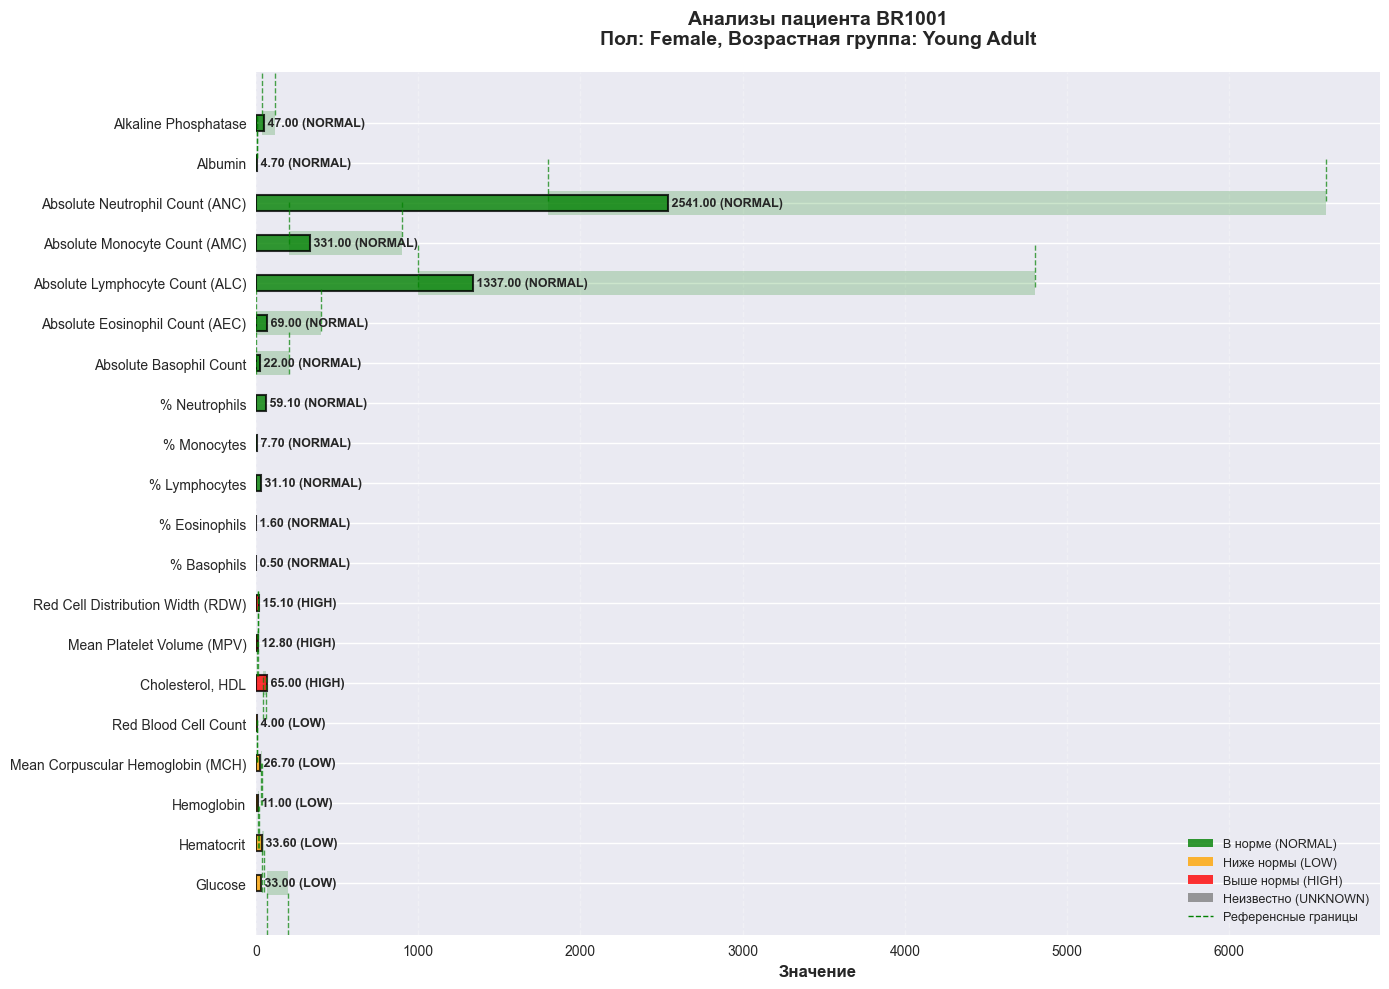


Детальная информация по анализам пациента BR1001
Тест                                     Значение     Норма                Статус    
--------------------------------------------------------------------------------
Glucose                                  33.00        70.00 - 199.00       LOW        (офиц.)
Hematocrit                               33.60        39.20 - 50.20        LOW        (офиц.)
Hemoglobin                               11.00        12.10 - 18.10        LOW        (офиц.)
Mean Corpuscular Hemoglobin (MCH)        26.70        27.50 - 35.10        LOW        (офиц.)
Red Blood Cell Count                     4.00         4.18 - 6.09          LOW        (офиц.)
Cholesterol, HDL                         65.00        40.00 - 59.00        HIGH       (офиц.)
Mean Platelet Volume (MPV)               12.80        7.20 - 11.70         HIGH       (офиц.)
Red Cell Distribution Width (RDW)        15.10        11.70 - 14.20        HIGH       (офиц.)
% Basophils                    

Графики сохранены в: output\data_distributions.png


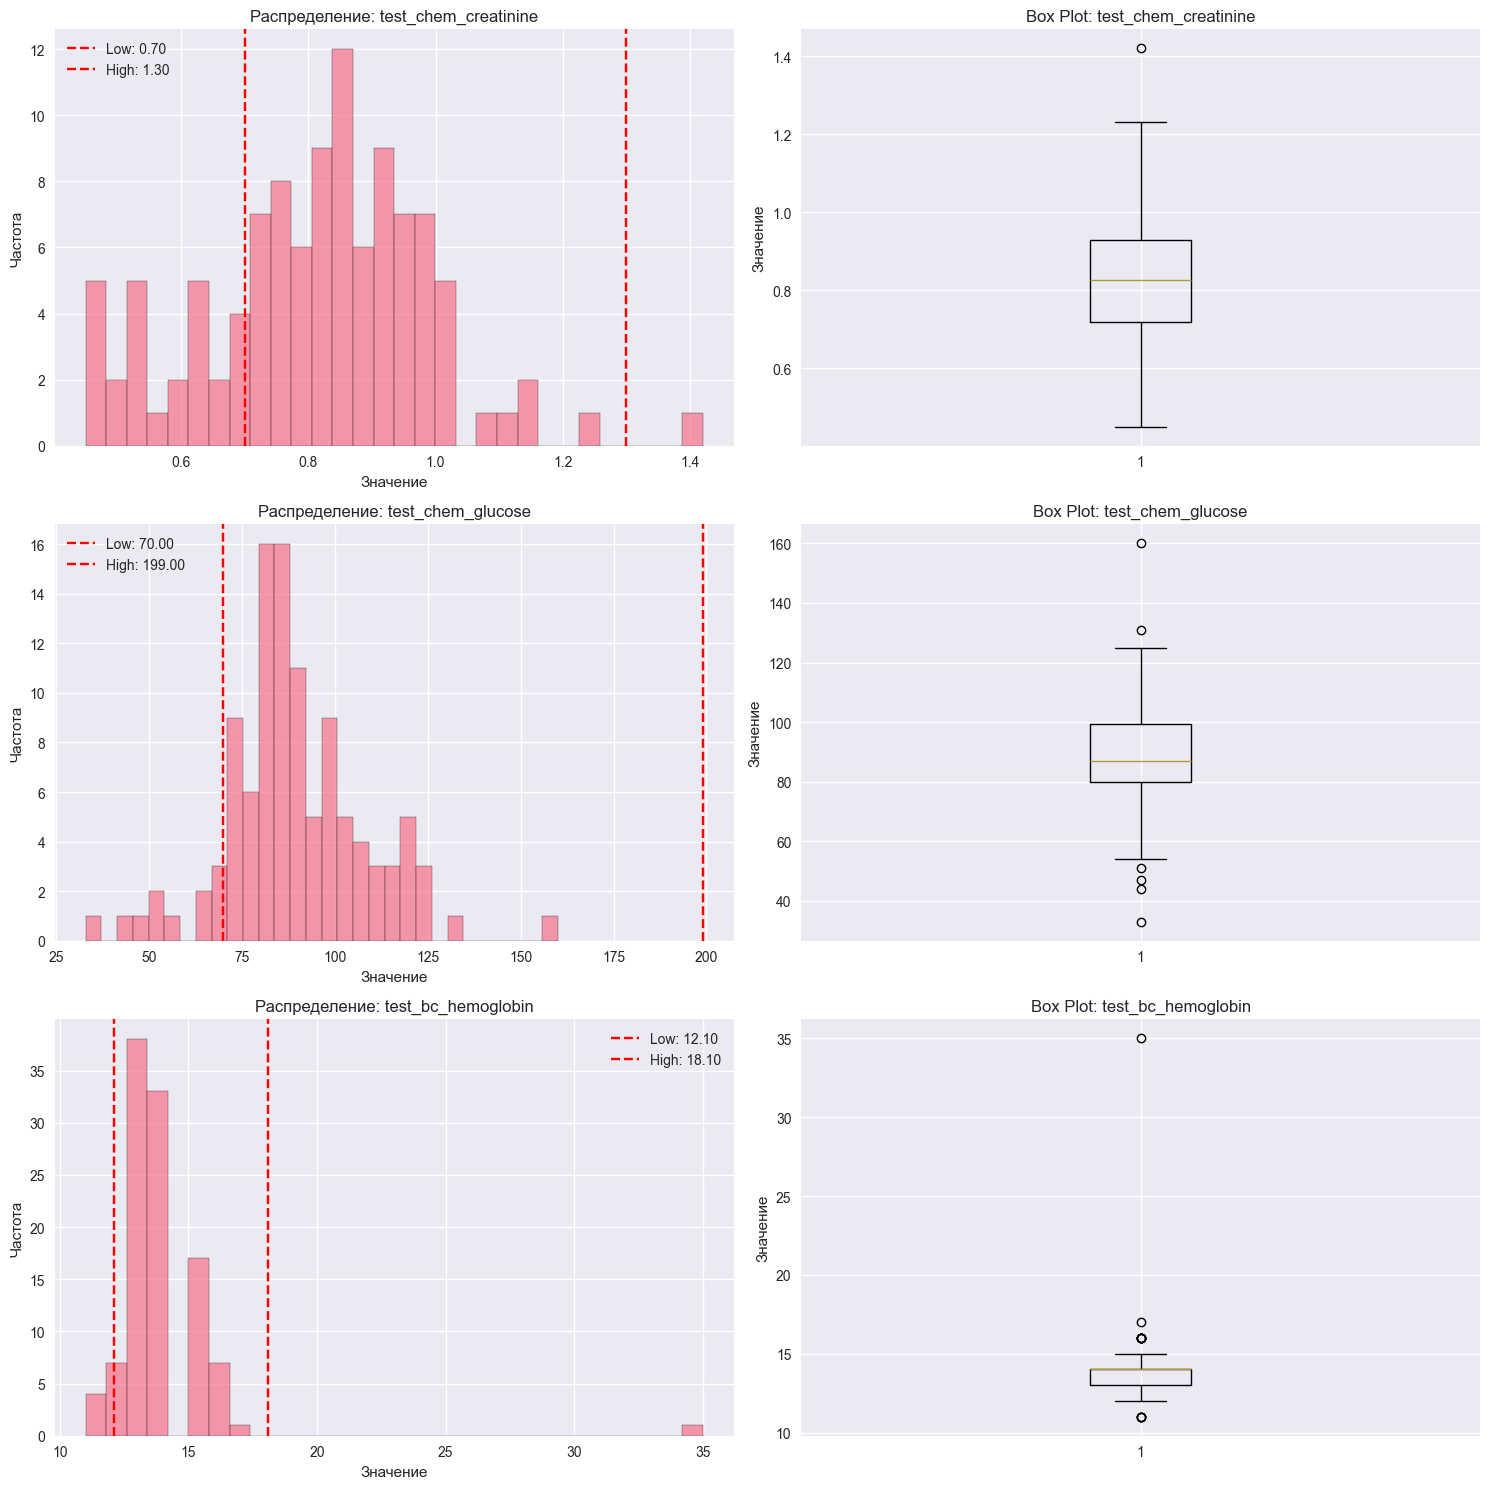

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Выбираем несколько тестов для визуализации
test_cols_to_plot = [
    col for col in df_final.columns 
    if col.startswith('test_') and 
    col in ['test_chem_glucose', 'test_bc_hemoglobin', 'test_chem_creatinine']
]

if len(test_cols_to_plot) > 0:
    fig, axes = plt.subplots(len(test_cols_to_plot), 2, figsize=(15, 5*len(test_cols_to_plot)))
    if len(test_cols_to_plot) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, test_col in enumerate(test_cols_to_plot):
        data = df_final[test_col].dropna()
        
        # Гистограмма
        axes[idx, 0].hist(data, bins=30, edgecolor='black', alpha=0.7)
        axes[idx, 0].set_title(f'Распределение: {test_col}')
        axes[idx, 0].set_xlabel('Значение')
        axes[idx, 0].set_ylabel('Частота')
        
        # Добавляем референсы
        if test_col in provisional_refs:
            ref = provisional_refs[test_col]
            axes[idx, 0].axvline(ref['low'], color='red', linestyle='--', label=f"Low: {ref['low']:.2f}")
            axes[idx, 0].axvline(ref['high'], color='red', linestyle='--', label=f"High: {ref['high']:.2f}")
            axes[idx, 0].legend()
        
        # Box plot
        axes[idx, 1].boxplot(data, vert=True)
        axes[idx, 1].set_title(f'Box Plot: {test_col}')
        axes[idx, 1].set_ylabel('Значение')
    
    plt.tight_layout()
    plot_file = os.path.join(OUTPUT_DIR, 'data_distributions.png')
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print(f"Графики сохранены в: {plot_file}")
    plt.show()
else:
    print("Не найдено тестов для визуализации")
